In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *
import itertools
#from nilearn import image, plotting, datasets
#import nibabel as nib
import pdb
import os
import warnings
warnings.filterwarnings("ignore")

curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'
data_dir = f"/lab_data/behrmannlab/vlad/ginn/modelling"
results_dir = f'{curr_dir}/results'
#training info

vid = 'DM-clip'

rois = ['lLO','rLO','lFFA', 'rFFA']
ages = [ '5', '6', '7', 'adult']

lLO


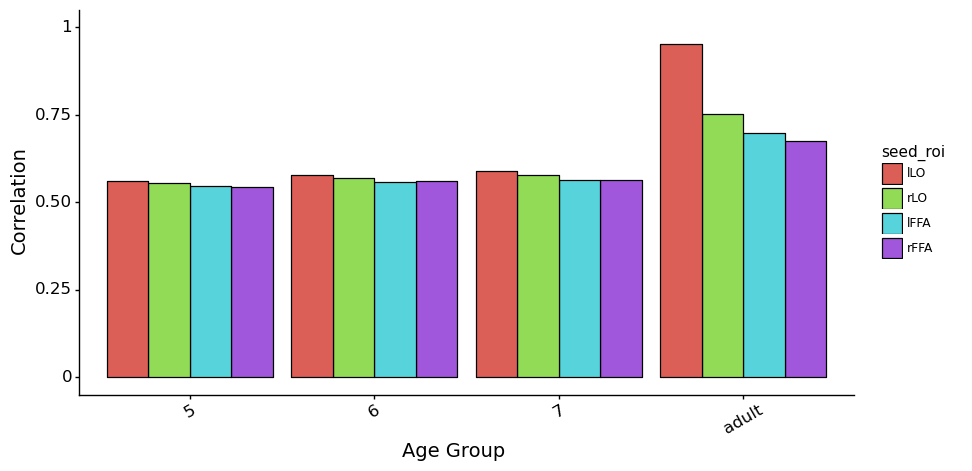


rLO


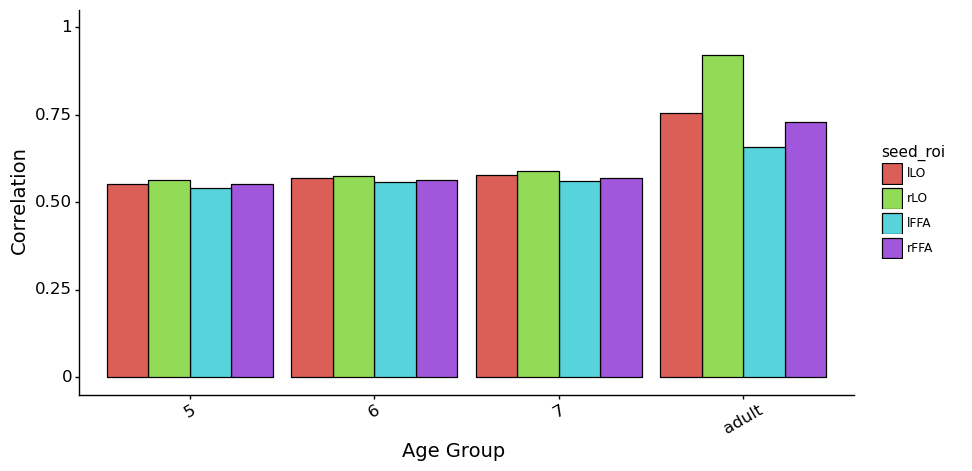


lFFA


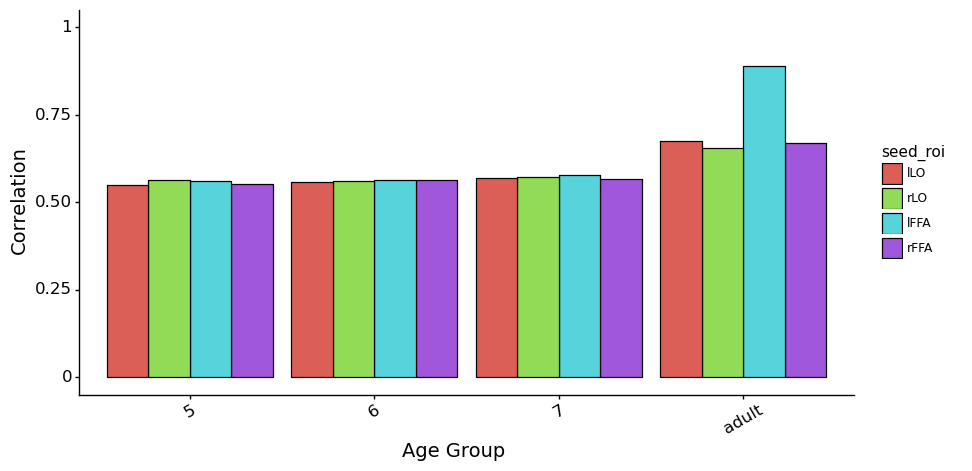


rFFA


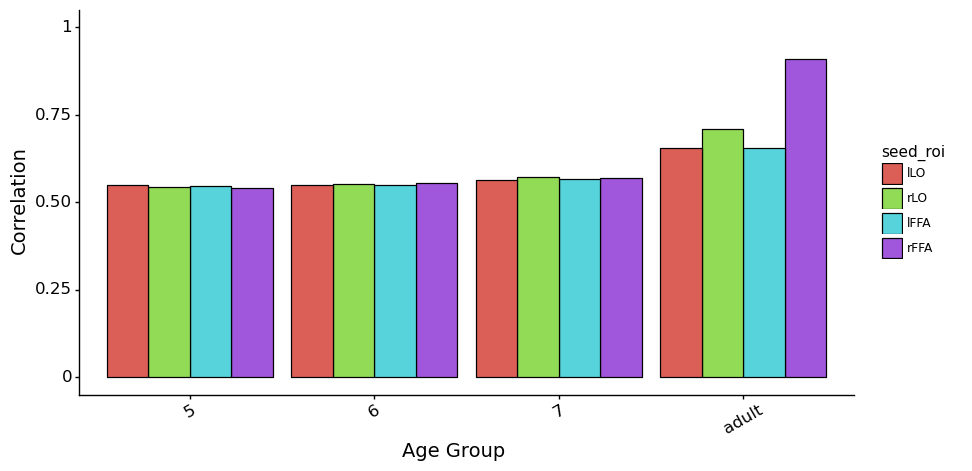


lA1


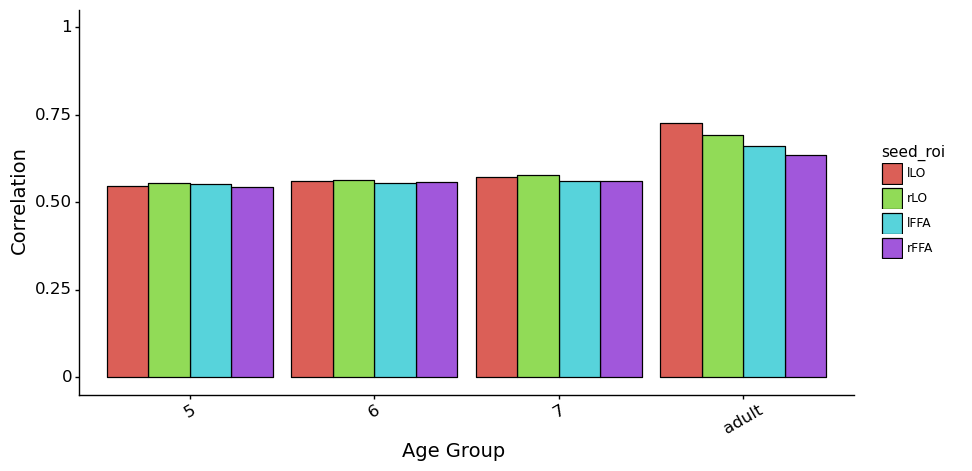


rA1


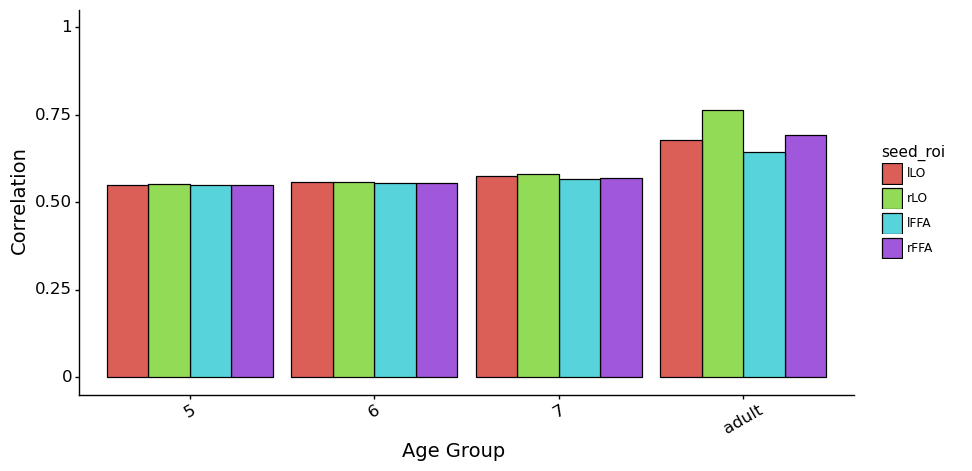

In [9]:
"""
MVPD with cross-val on video
"""
exp = 'mvpd'
df = pd.read_csv(f'{results_dir}/{exp}/human_summary_50_srm_sub_cv.csv')
df['age'] = df['age'].astype(str)
df['age'][df['age']== '18'] = 'adult'

target_rois = ['lLO','rLO','lFFA', 'rFFA', 'lA1', 'rA1']

for roi in target_rois:
    print(roi)

    summary_df = df[df['roi'] == roi]
    summary_df['age'] = pd.Categorical(summary_df['age'], categories = ages, ordered = False)
    summary_df['seed_roi'] = pd.Categorical(summary_df['seed_roi'], categories = rois, ordered = False)

    plot = ggplot(summary_df, aes(x = 'age', y = 'corr', fill = 'seed_roi')) + \
    geom_col(stat='identity',color = 'black', position = 'dodge') + theme_classic() + \
    xlab('Age Group') + ylab('Correlation') + ylim(0, 1) + \
    theme(text = element_text(color ='black'), 
        axis_text_x= element_text(angle = 30, size = 12),
        axis_text_y= element_text(size = 12),
        axis_title=element_text(size = 14),
        axis_line=element_line(), 
        panel_border=element_blank(),
        figure_size = (10, 5))
    
    print(plot)
    del plot



In [3]:
summary_df

,Unnamed: 0,age,roi,corr,seed_age,seed_roi
0,0,5,lLO,0.561680,18,lLO
6,6,6,lLO,0.578847,18,lLO
12,12,7,lLO,0.590296,18,lLO
18,18,adult,lLO,0.950997,18,lLO
24,0,5,lLO,0.555274,18,rLO
30,6,6,lLO,0.569074,18,rLO
36,12,7,lLO,0.576851,18,rLO
42,18,adult,lLO,0.751884,18,rLO
48,0,5,lLO,0.547512,18,lFFA
54,6,6,lLO,0.557677,18,lFFA


lLO


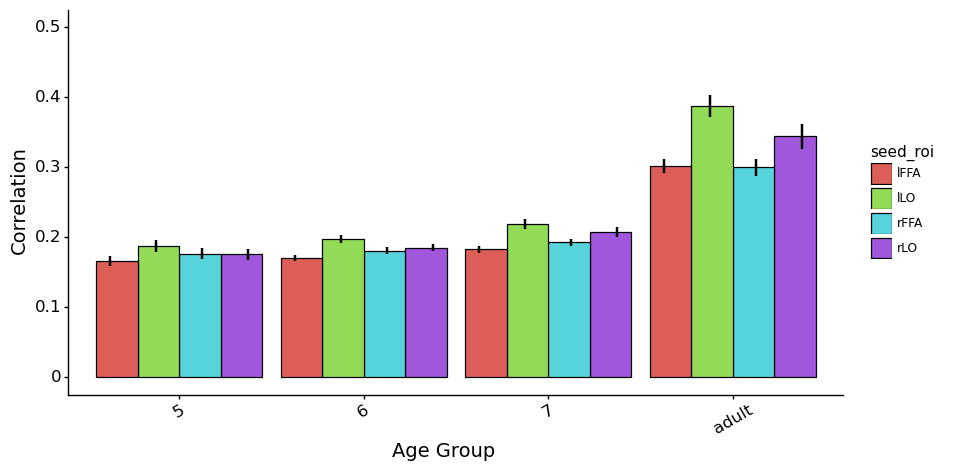


rLO


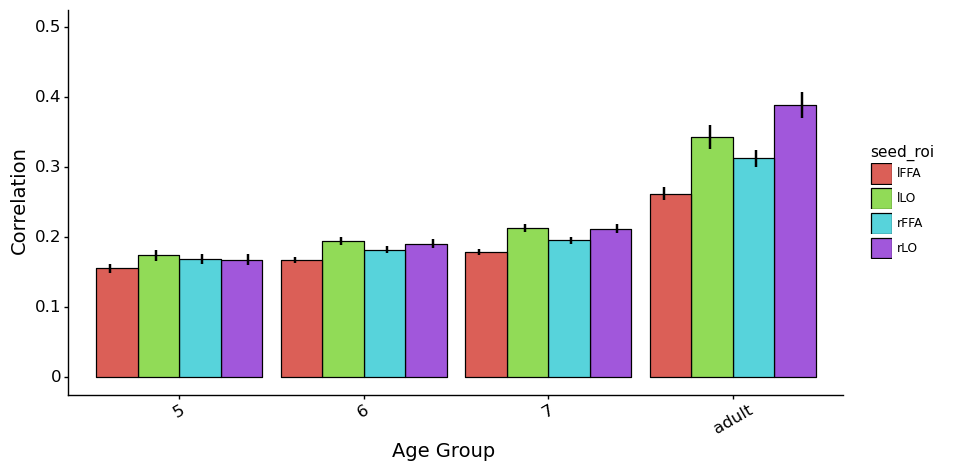


lFFA


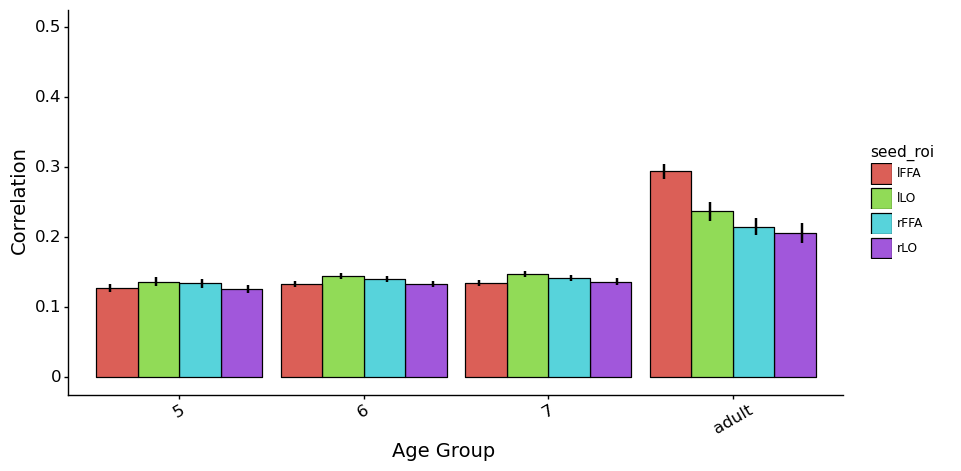


rFFA


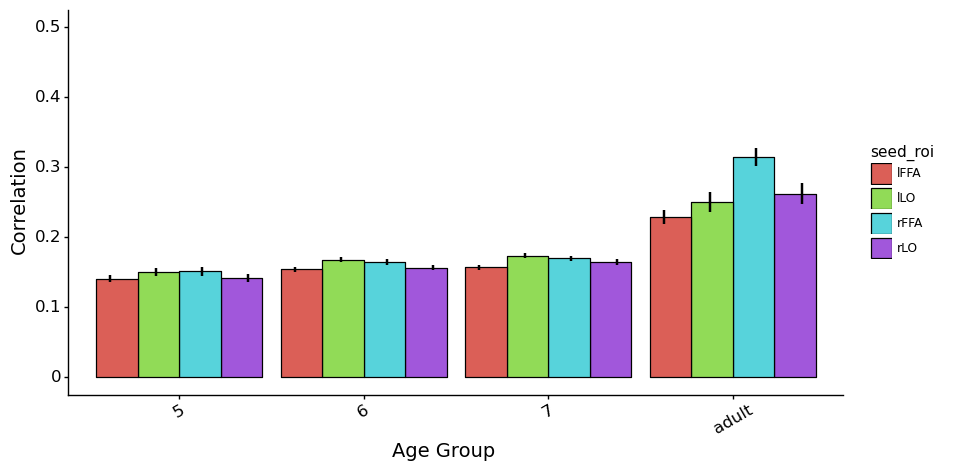

In [28]:
"""
RSA using each individual
"""
exp = 'rsa'
df = pd.read_csv(f'{results_dir}/{exp}/individual_rsa_summary.csv')
df = df[df['seed_roi'] != 'lOFA']
df = df[df['seed_roi'] != 'rOFA']

df['target_age'] = df['target_age'].apply(np.floor).astype(int)
df['target_age'][df['target_age'] >= 18] = 18
df['target_age'] = df['target_age'].astype(str)
df['target_age'][df['target_age']== '18'] = 'adult' 

curr_df = df.groupby(["target_age", "target_roi","seed_roi"]).mean().reset_index()
curr_df['se'] = df.groupby(["target_age", "target_roi","seed_roi"]).sem().reset_index()['corr']


for roi_vals in enumerate(rois):
        roi = f'{roi_vals[1]}'
        print(roi)
        summary_df = curr_df[(curr_df['target_roi'] == roi)]
        summary_df['target_age'] = pd.Categorical(summary_df['target_age'], categories = ages, ordered = False)
        #summary_df['seed_roi'] = pd.Categorical(summary_df['seed_roi'], categories = rois, ordered = False)


        
        
        plot = ggplot(summary_df, aes(x = 'target_age', y = 'corr', fill = 'seed_roi')) + \
            geom_col(stat='identity',color = 'black', position='dodge') + theme_classic() + \
            xlab('Age Group') + ylab('Correlation') + ylim(0, 0.5) + \
            geom_linerange(aes(x='target_age',  ymax = 'corr + se', ymin = 'corr - se'), size = 1, position=position_dodge2(width=1)) + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(angle = 30, size = 12),
                axis_text_y= element_text(size = 12),
                axis_title=element_text(size = 14),
                axis_line=element_line(), 
                panel_border=element_blank(),
                figure_size = (10, 5))

        print(plot)
        del plot

In [22]:
curr_df

,target_age,target_roi,seed_roi,seed_age,corr,se
0,5,lFFA,lFFA,18.0,0.126997,0.005654
1,5,lFFA,lLO,18.0,0.136164,0.006457
2,5,lFFA,lOFA,18.0,0.118446,0.005407
3,5,lFFA,rFFA,18.0,0.134329,0.006412
4,5,lFFA,rLO,18.0,0.125885,0.005789
...,...,...,...,...,...,...
139,adult,rOFA,lLO,18.0,0.274803,0.015133
140,adult,rOFA,lOFA,18.0,0.229816,0.010185
141,adult,rOFA,rFFA,18.0,0.262815,0.012621
142,adult,rOFA,rLO,18.0,0.306462,0.015997


lLO


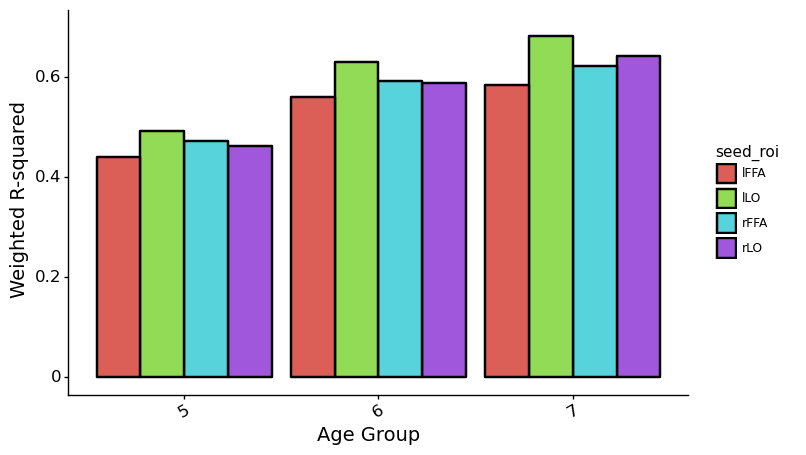


rLO


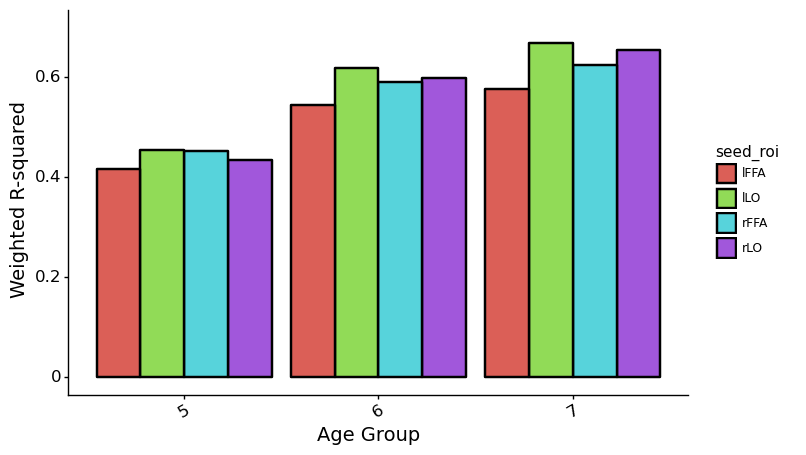


lFFA


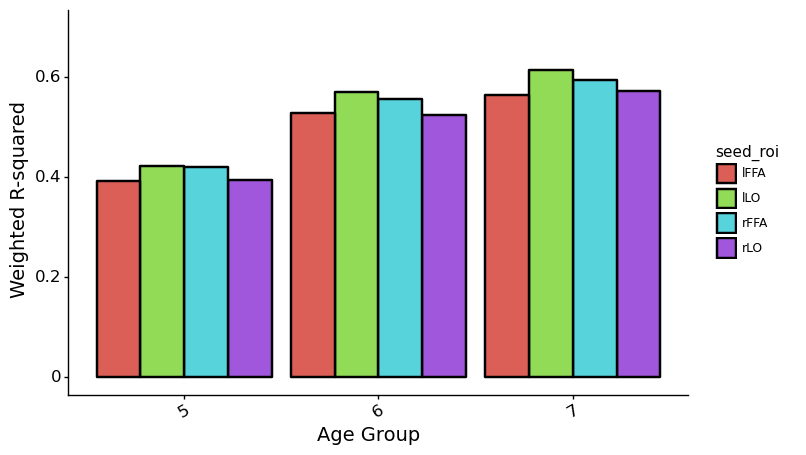


rFFA


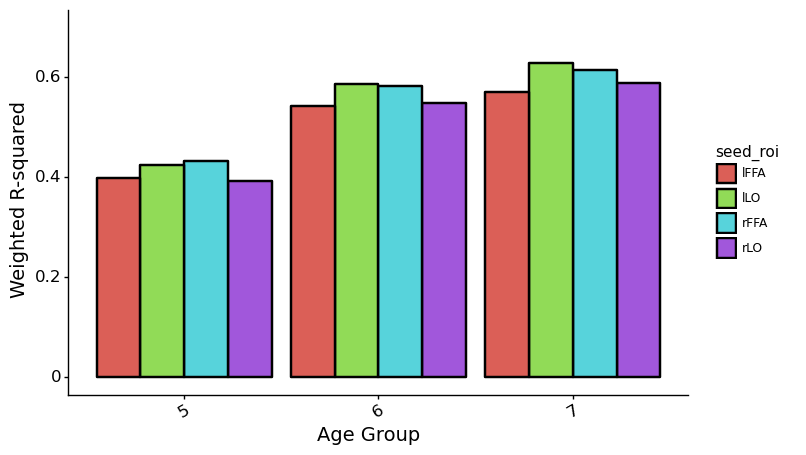

In [19]:
"""
RSA using adult RDM as predictor
"""
exp = 'rsa'

df = pd.read_csv(f'{results_dir}/{exp}/human_rsa_summary.csv')
df = df[df['seed_roi'] != 'lOFA']
df = df[df['seed_roi'] != 'rOFA']
#remove OFA for now
for target_roi in rois:
    summary_df = df[df['target_roi'] == target_roi]
    print(target_roi)
    plot = ggplot(summary_df, aes(x = 'target_age', y = 'corr', fill = 'seed_roi')) + \
                    geom_col(stat='identity', size = 1, color = 'Black',position='dodge') + \
                    theme_classic() + xlab('Age Group') + ylab('Weighted R-squared') + ylim(0,.7) + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (8, 5))
    
    print(plot)



lLO


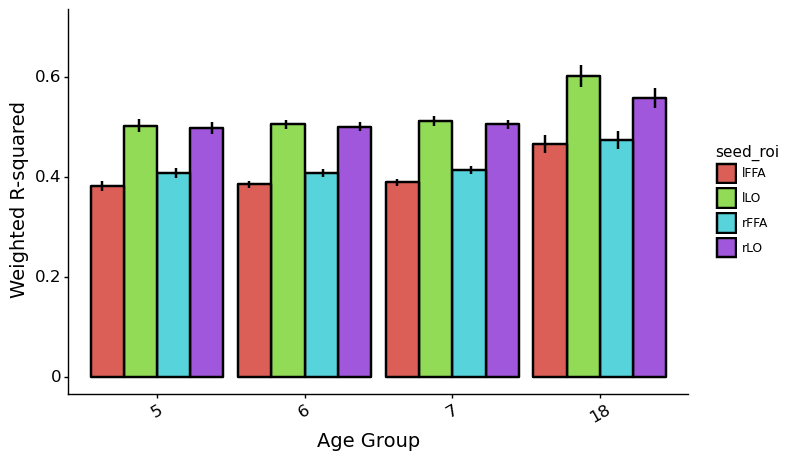


   target_roi seed_roi age        r2        se
0         lLO      lLO   5  0.502507  0.012766
1         lLO      lLO   6  0.504900  0.009113
2         lLO      lLO   7  0.511160  0.009703
3         lLO      lLO  18  0.600871  0.021966
4         lLO      rLO   5  0.497757  0.012633
5         lLO      rLO   6  0.500560  0.008911
6         lLO      rLO   7  0.505083  0.009594
7         lLO      rLO  18  0.557976  0.020478
8         lLO     lFFA   5  0.382010  0.010624
9         lLO     lFFA   6  0.385463  0.007050
10        lLO     lFFA   7  0.389400  0.007364
11        lLO     lFFA  18  0.465615  0.017496
12        lLO     rFFA   5  0.407828  0.010847
13        lLO     rFFA   6  0.408385  0.007591
14        lLO     rFFA   7  0.414529  0.008000
15        lLO     rFFA  18  0.473652  0.018544
rLO


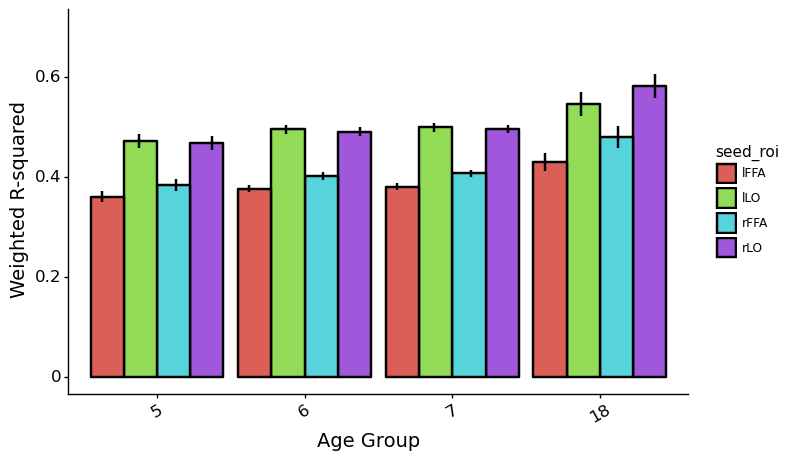


   target_roi seed_roi age        r2        se
0         rLO      lLO   5  0.471948  0.014561
1         rLO      lLO   6  0.495293  0.009349
2         rLO      lLO   7  0.499023  0.008611
3         rLO      lLO  18  0.545967  0.023321
4         rLO      rLO   5  0.467937  0.014371
5         rLO      rLO   6  0.490661  0.009093
6         rLO      rLO   7  0.495594  0.008484
7         rLO      rLO  18  0.581276  0.023944
8         rLO     lFFA   5  0.360608  0.011001
9         rLO     lFFA   6  0.376762  0.006760
10        rLO     lFFA   7  0.380290  0.006596
11        rLO     lFFA  18  0.429947  0.017621
12        rLO     rFFA   5  0.384150  0.011544
13        rLO     rFFA   6  0.401757  0.007468
14        rLO     rFFA   7  0.406985  0.007088
15        rLO     rFFA  18  0.479725  0.021123
lFFA


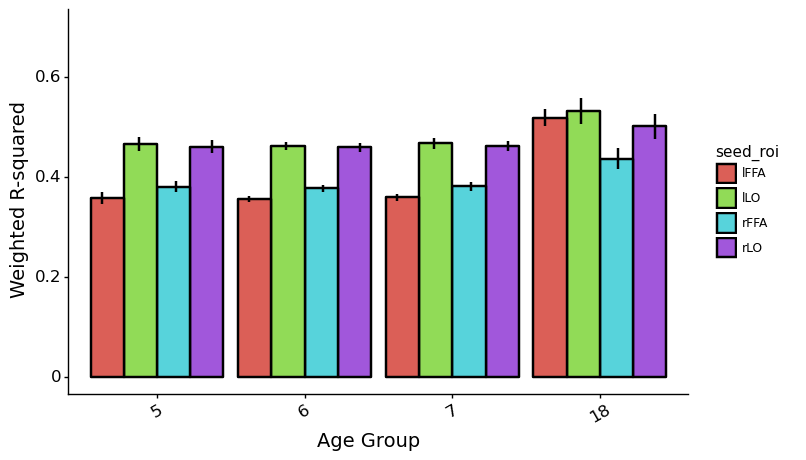


   target_roi seed_roi age        r2        se
0        lFFA      lLO   5  0.465763  0.014412
1        lFFA      lLO   6  0.461992  0.008723
2        lFFA      lLO   7  0.467331  0.010748
3        lFFA      lLO  18  0.532001  0.025579
4        lFFA      rLO   5  0.460715  0.013739
5        lFFA      rLO   6  0.458880  0.008700
6        lFFA      rLO   7  0.462008  0.010609
7        lFFA      rLO  18  0.501328  0.024738
8        lFFA     lFFA   5  0.358172  0.011490
9        lFFA     lFFA   6  0.355618  0.006110
10       lFFA     lFFA   7  0.358946  0.007763
11       lFFA     lFFA  18  0.518441  0.017211
12       lFFA     rFFA   5  0.380675  0.011314
13       lFFA     rFFA   6  0.377441  0.006735
14       lFFA     rFFA   7  0.381166  0.008468
15       lFFA     rFFA  18  0.435928  0.020936
rFFA


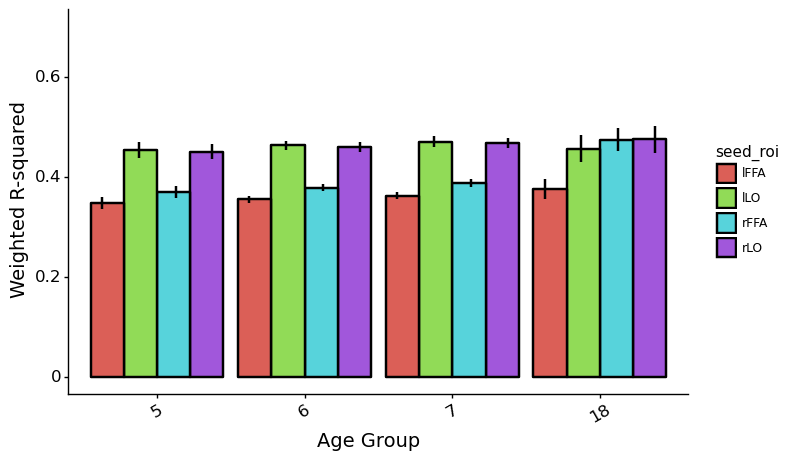


   target_roi seed_roi age        r2        se
0        rFFA      lLO   5  0.453812  0.015598
1        rFFA      lLO   6  0.463144  0.009308
2        rFFA      lLO   7  0.470750  0.010411
3        rFFA      lLO  18  0.456388  0.026583
4        rFFA      rLO   5  0.450019  0.015198
5        rFFA      rLO   6  0.459792  0.009157
6        rFFA      rLO   7  0.467650  0.010310
7        rFFA      rLO  18  0.475173  0.027525
8        rFFA     lFFA   5  0.348274  0.011486
9        rFFA     lFFA   6  0.355366  0.006653
10       rFFA     lFFA   7  0.362508  0.007466
11       rFFA     lFFA  18  0.376258  0.020503
12       rFFA     rFFA   5  0.370475  0.011914
13       rFFA     rFFA   6  0.378323  0.007367
14       rFFA     rFFA   7  0.387734  0.008241
15       rFFA     rFFA  18  0.474573  0.022831


In [8]:
"""
MVPD using SRM as predictors
"""
exp = 'mvpd'

#suf = '_all'
n_feat = 100


seed_age = 18


# Load data
df = pd.read_csv(f'{results_dir}/{exp}/srm_summary_{n_feat}.csv')
df['age'] = df['age'].apply(np.floor)
df['age'][df['age'] >= 18] = 18
'''
summary_df = df.groupby(['roi','seed_roi','age']).mean()

plot = ggplot(summary_df, aes(x = 'age', y = 'R2', fill = 'seed_roi')) + \
                    geom_col(stat='identity', size = 1, color = 'Black',position='dodge') + \
                    geom_linerange(aes(x='age',  ymax = 'R2 + se', ymin = 'R2 - se'), size = 1, position=position_dodge2(width=1)) + \
                    theme_classic() + xlab('Age Group') + ylab('Weighted R-squared') + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (8, 5))
    
print(plot)
'''

for target_roi in rois:
    print(target_roi)
    summary_df = pd.DataFrame(columns = ['target_roi','seed_roi', 'age', 'r2', 'se'])
    for seed_roi in rois:
        for age in ages:
            curr_df = df[(df['roi'] == target_roi) & (df['seed_roi'] == seed_roi) & (df['age'] == age)]

            summary_df = summary_df.append(pd.Series([target_roi,seed_roi, age, curr_df['r2'].mean(), curr_df['r2'].sem()],
                index = summary_df.columns), ignore_index=True)
    
    summary_df['r2'] = summary_df['r2'].astype(float)
    summary_df['se'] = summary_df['se'].astype(float)
    plot = ggplot(summary_df, aes(x = 'age', y = 'r2', fill = 'seed_roi')) + \
                    geom_col(stat='identity', size = 1, color = 'Black',position='dodge') + \
                    geom_linerange(aes(x='age',  ymax = 'r2 + se', ymin = 'r2 - se'), size = 1, position=position_dodge2(width=1)) + \
                    theme_classic() + xlab('Age Group') + ylab('Weighted R-squared') + ylim(0,.7) + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (8, 5))
    
    print(plot)
    print(summary_df)
    del plot    
            



lLO


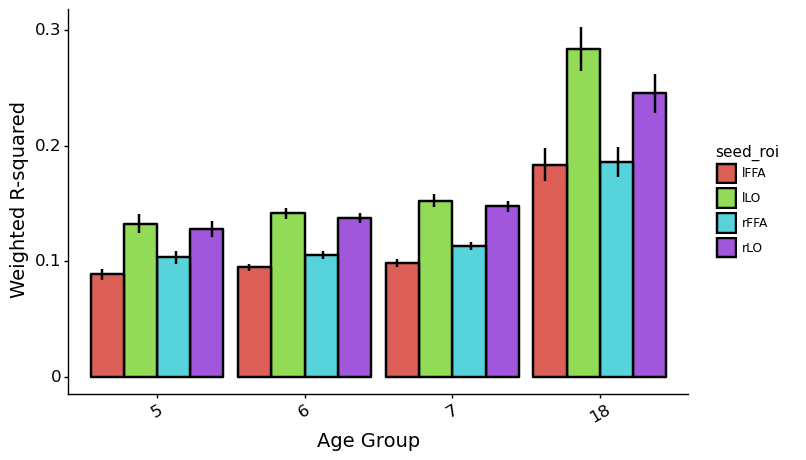


rLO


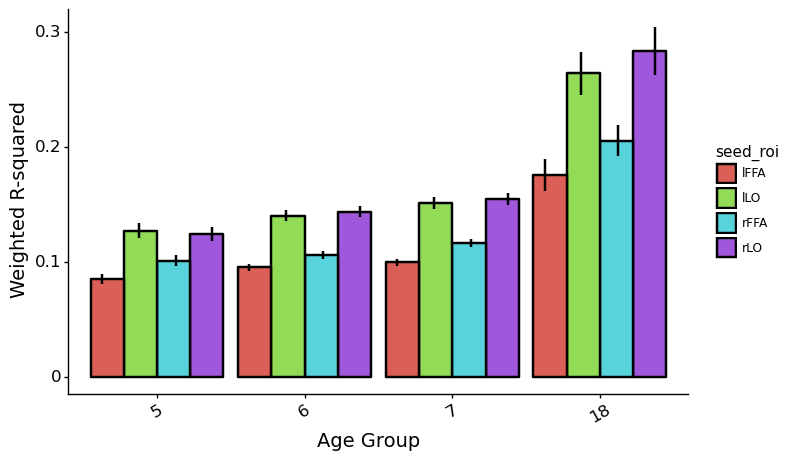


lFFA


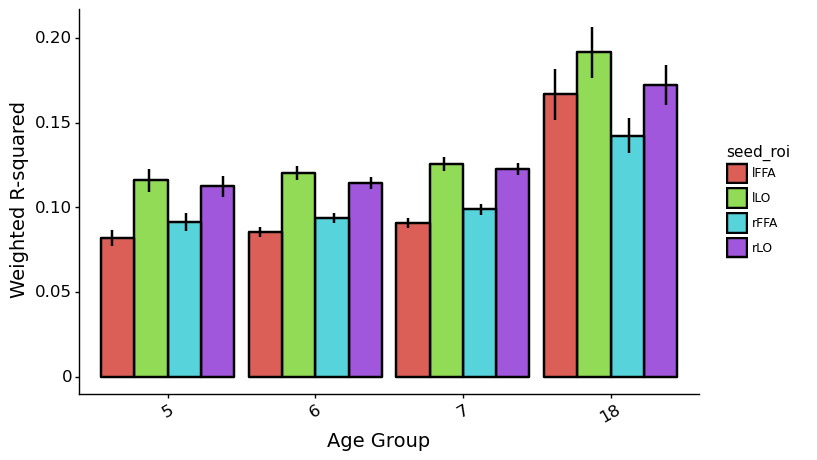


rFFA


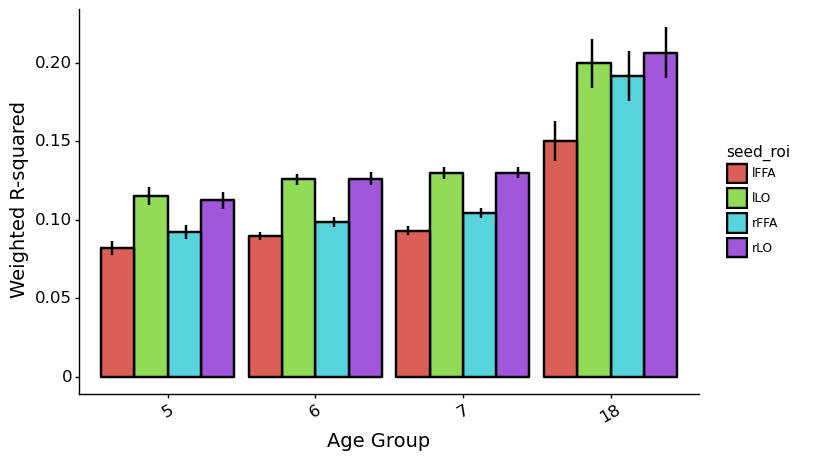

In [5]:
"""
MVPD of face regions using AVG adult brain
"""
exp = 'mvpd'
suf = '_10_pcs_r2'
#suf = '_all'

rois = ['lLO','rLO','lFFA', 'rFFA']
ages = [ 5, 6, 7, 18]
seed_age = 18

for target_roi in rois:
    summary_df = pd.DataFrame(columns = ['target_roi','seed_roi', 'age', 'R2', 'se'])
    for seed_roi in rois:
        curr_df = pd.read_csv(f'{results_dir}/{exp}/{seed_roi}_{seed_age}_summary{suf}.csv')
        curr_df = curr_df[curr_df['target_roi']==target_roi]
        curr_df['age_group'] = curr_df['target_age'].apply(np.floor)
        curr_df['age_group'][curr_df['age_group']>=18] = 18

        for age in ages:
            age_df = curr_df[curr_df['age_group']==age]
            curr_data = pd.Series([target_roi, seed_roi, age, age_df['r2'].mean(), age_df['r2'].sem()], index = summary_df.columns)
            
            summary_df = summary_df.append(curr_data, ignore_index=True)
    


    summary_df['R2'] = summary_df['R2'].astype(float)
    summary_df['se'] = summary_df['se'].astype(float)
    #plot = ggplot(summary_df, aes(x = 'age', y = 'R2', fill = 'seed_roi')) + geom_col() + ylim(0,1)
    print(target_roi)
    plot = ggplot(summary_df, aes(x = 'age', y = 'R2', fill = 'seed_roi')) + \
                    geom_col(stat='identity', size = 1, color = 'Black',position='dodge') + \
                    geom_linerange(aes(x='age',  ymax = 'R2 + se', ymin = 'R2 - se'), size = 1, position=position_dodge2(width=1)) + \
                    theme_classic() + xlab('Age Group') + ylab('Weighted R-squared') + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (8, 5))
    
    print(plot)
    del plot
    
    





In [21]:
"""
Model setup

"""

model_type = ['cornet_z_cl', 'cornet_z_sl']

train_type = ['random','imagenet_noface', 'imagenet_oneface',
'imagenet_vggface', 'vggface_oneobject', 'vggface']

layer_type = [['decoder', 'decoder', 'decoder'],['decoder', 'decoder', 'decoder']]
sublayer_type = [['avgpool', 'linear','l2norm'],['avgpool', 'linear','output']]


seed = 1

suf = ''

In [28]:
"""
Plot classification mean data
"""
exp = 'classify'

cond = ['upright','inverted']
test_type = ['objects', 'faces']

suf = ''

for mm in enumerate(model_type):
    for ll in sublayer_type[mm[0]]:
        
        summary_df = pd.DataFrame(columns = ['arch','train_type','image_type', 'condition', 'acc', 'se'])
        for trt in train_type:
            for tt in test_type:
                for cc in cond:
                    
                    curr_df = pd.read_csv(f'{results_dir}/{exp}/{mm[1]}_{trt}_{ll}_{tt}_{cc}{suf}.csv')
                    curr_data = pd.Series([mm[1],trt,tt,cc, curr_df['acc'].mean(), curr_df['acc'].sem()],
                                            index = summary_df.columns)
                    summary_df = summary_df.append(curr_data, ignore_index=True)

            #summary_df = pd.concat([summary_df, curr_data])
        summary_df['acc'] = summary_df['acc'].astype(float)
        summary_df['se'] = summary_df['se'].astype(float)

        summary_df['condition'] = pd.Categorical(summary_df['condition'], categories = cond, ordered = False)
        summary_df['image_type'] = pd.Categorical(summary_df['image_type'], categories = test_type, ordered = False)
        summary_df['train_type'] = pd.Categorical(summary_df['train_type'], categories = train_type, ordered = False)


#plot = ggplot(summary_df, aes(x = 'model', y = 'acc', fill = 'image_type')) + geom_col(stat='identity', position='dodge') + \
#     lims(y=(0, .5))
        print([mm[1], ll])
        plot = ggplot(summary_df, aes(x = 'train_type', y = 'acc', color = 'condition')) + \
            geom_linerange(aes(x='train_type',  ymax = 'acc + se', ymin = 'acc - se', linetype = 'image_type'), size = 1,position=position_dodge2(width=.5)) + \
            geom_point(aes(shape = 'image_type'), size = 4, fill = 'White', stroke = 1,position=position_dodge2(width=.5)) + \
            geom_hline(yintercept=.03, linetype = 'dashed') + theme_classic() + xlab('Model Type') + ylab('Classification Accuracy') + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (10, 5))

        print(plot)
        del plot
        


NameError: name 'model_type' is not defined

In [17]:
print(f'{results_dir}/{exp}/{mm[1]}_{trt}_{layer}_{tt}_{cc}{suf}.csv')

/user_data/vayzenbe/GitHub_Repos/ginn/results/classify/cornet_z_cl_imagenet_noface_avgpool_objects_upright.csv


In [15]:
linear = summary_df

['cornet_z_cl', 'cropped_face', 'avgpool']


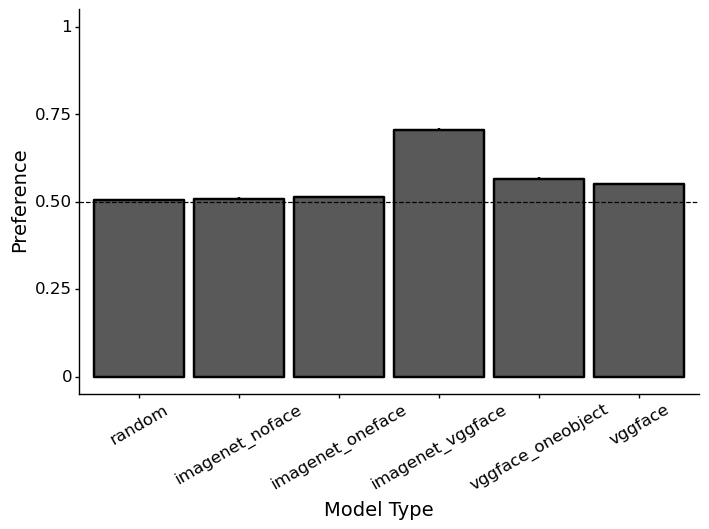


['cornet_z_cl', 'schematic', 'avgpool']


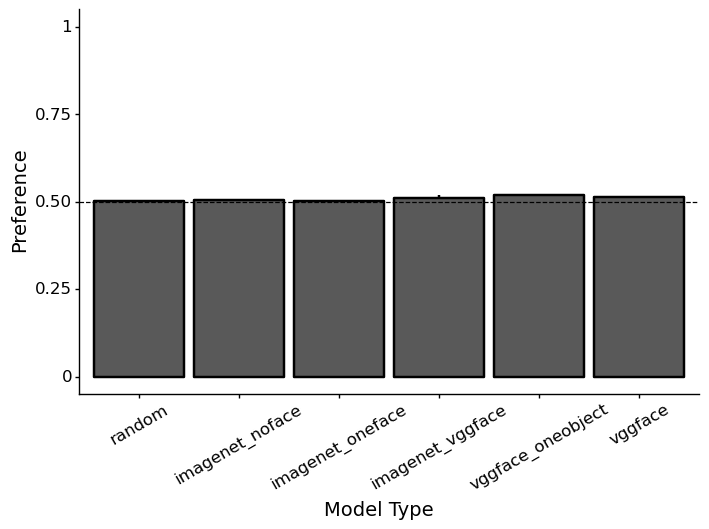


['cornet_z_cl', 'au', 'avgpool']


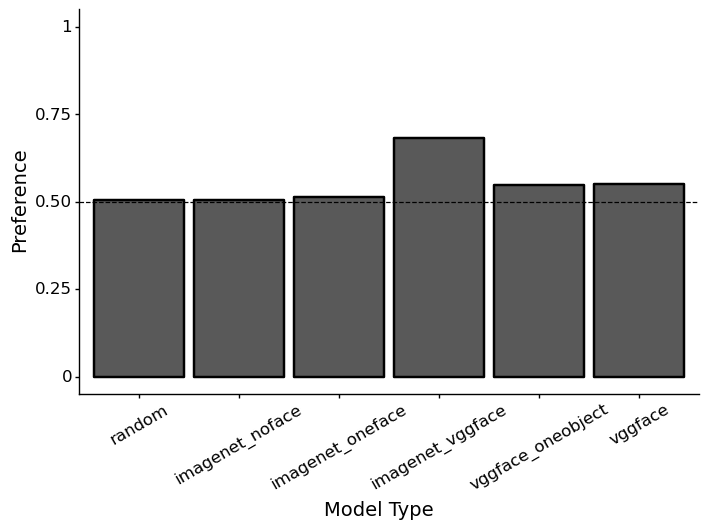


['cornet_z_cl', 'cropped_face', 'linear']


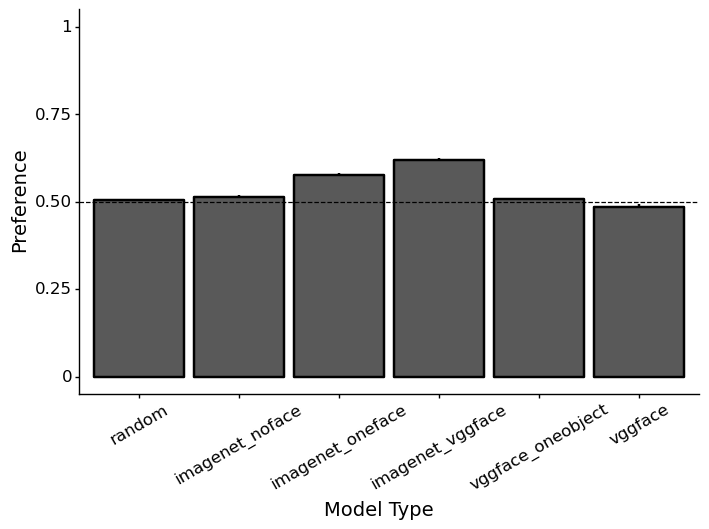


['cornet_z_cl', 'schematic', 'linear']


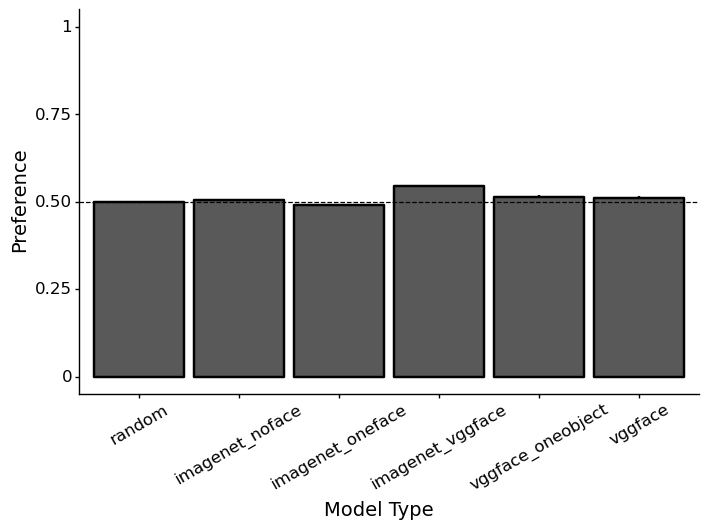


['cornet_z_cl', 'au', 'linear']


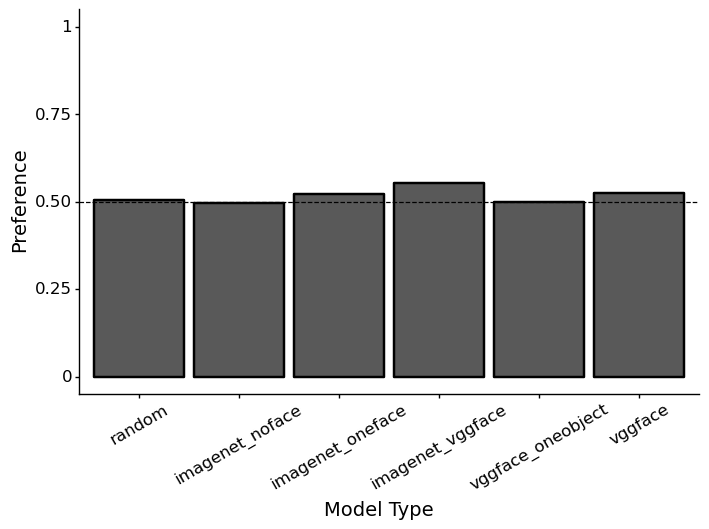


['cornet_z_cl', 'cropped_face', 'l2norm']


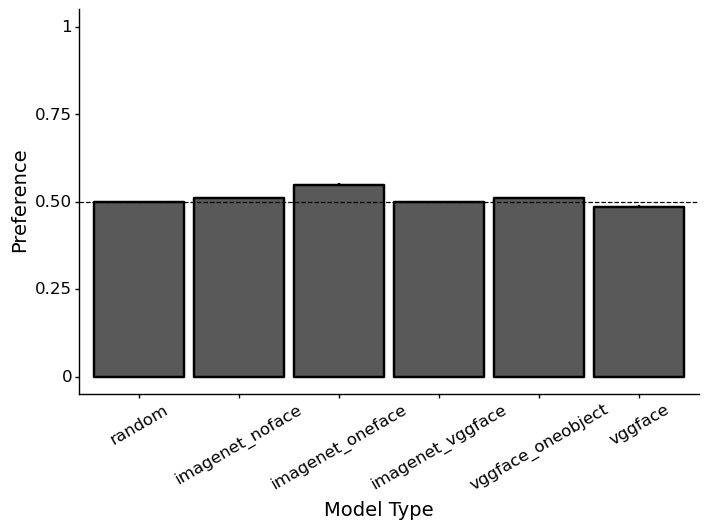


['cornet_z_cl', 'schematic', 'l2norm']


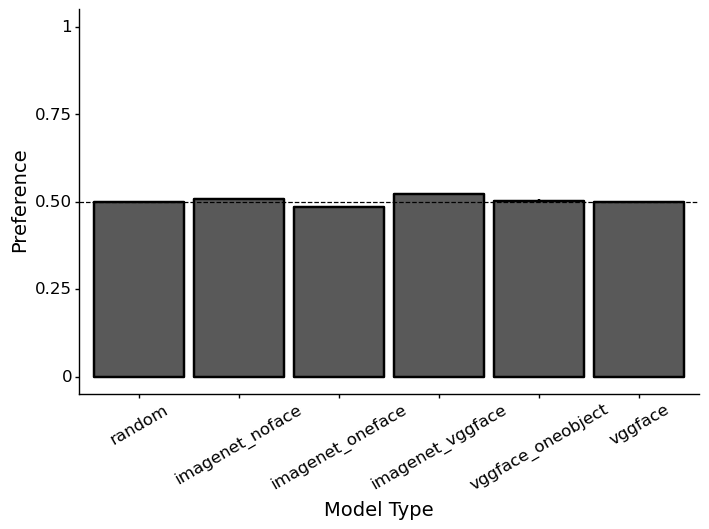


['cornet_z_cl', 'au', 'l2norm']


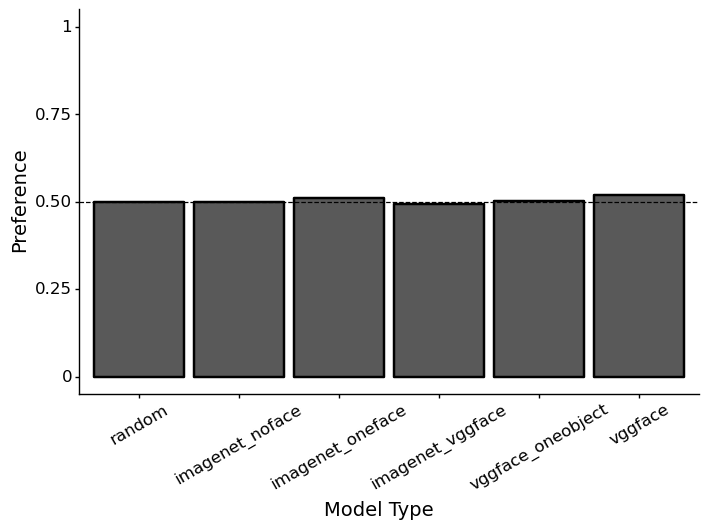


['cornet_z_sl', 'cropped_face', 'avgpool']


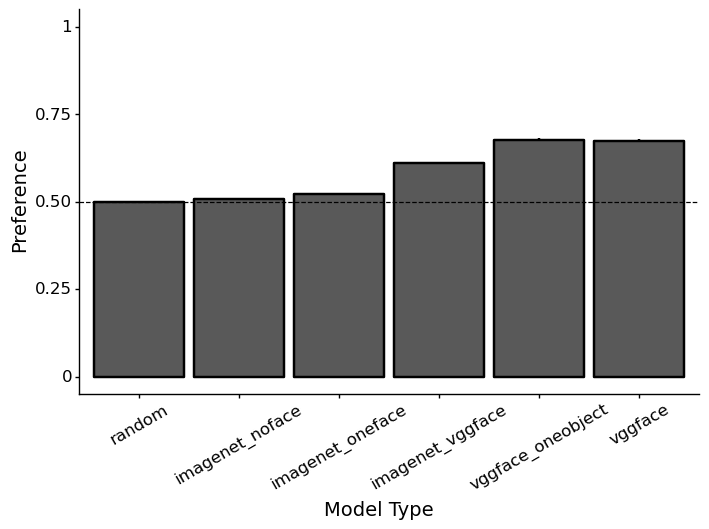


['cornet_z_sl', 'schematic', 'avgpool']


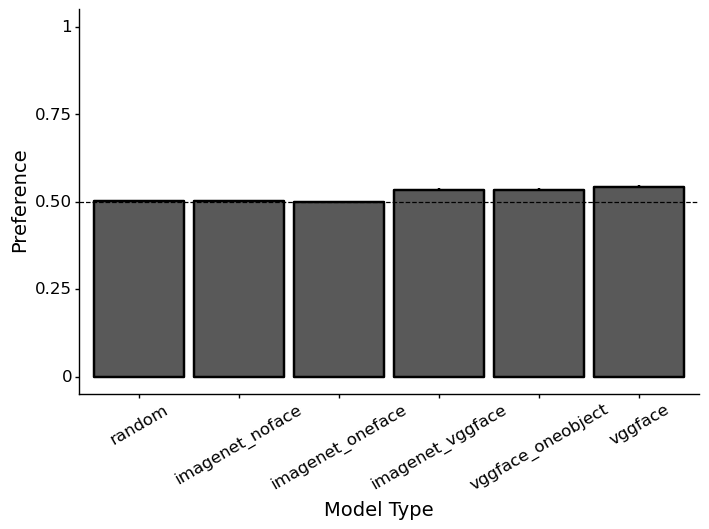


['cornet_z_sl', 'au', 'avgpool']


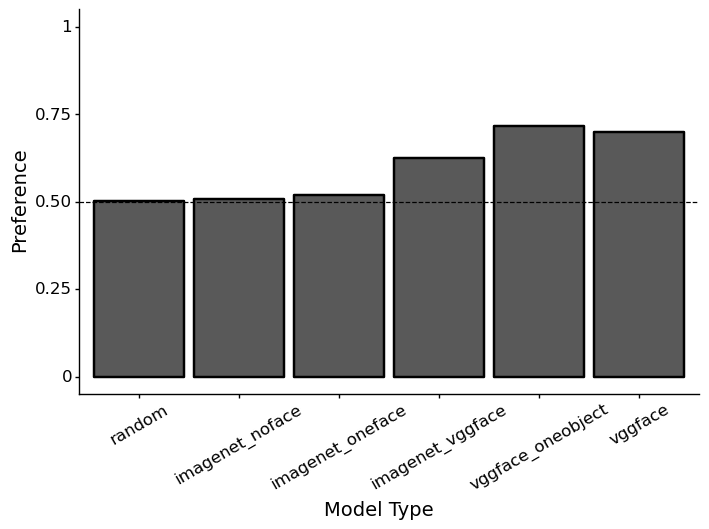


['cornet_z_sl', 'cropped_face', 'linear']


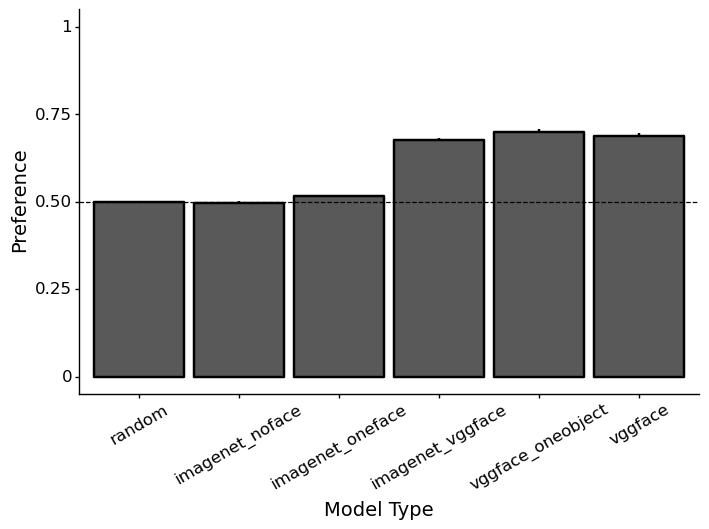


['cornet_z_sl', 'schematic', 'linear']


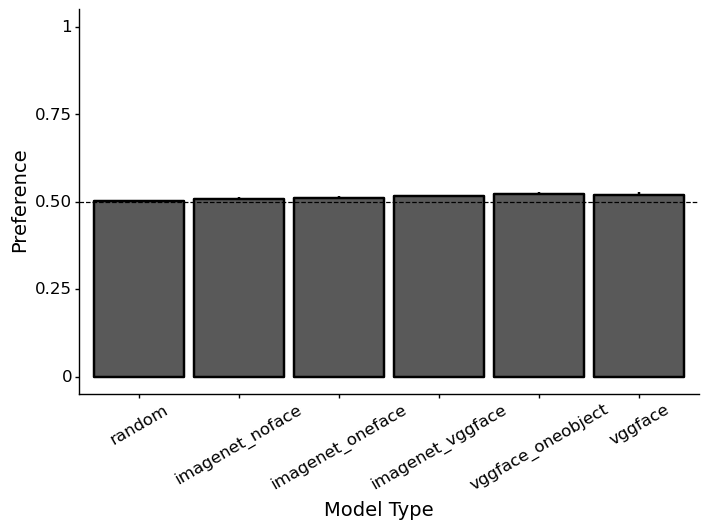


['cornet_z_sl', 'au', 'linear']


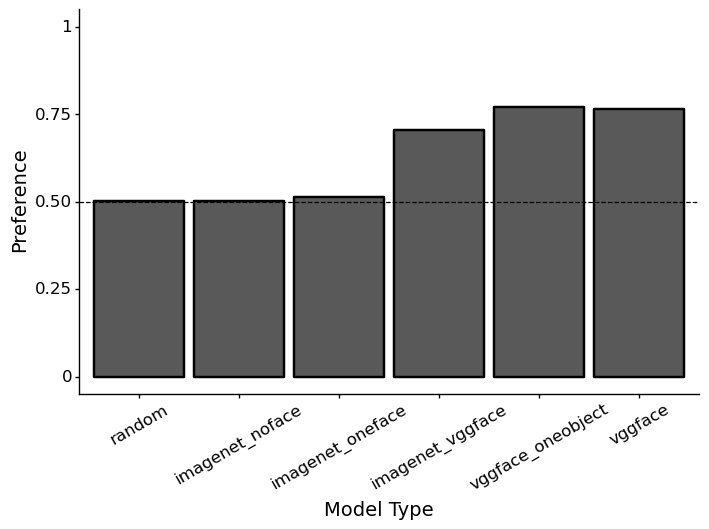


['cornet_z_sl', 'cropped_face', 'output']


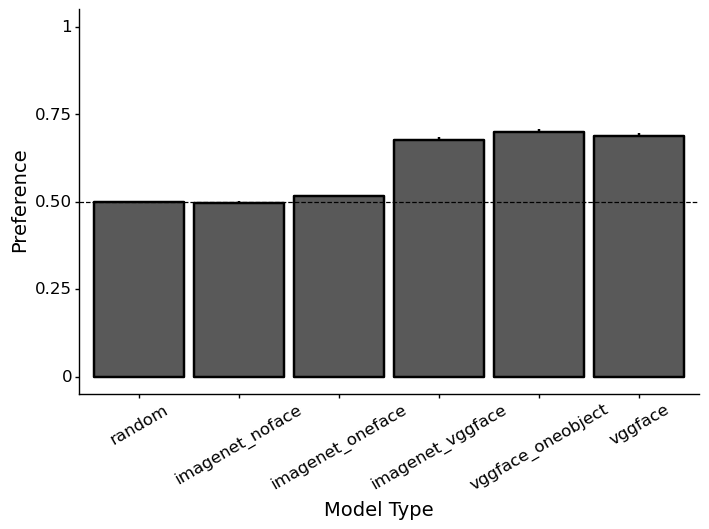


['cornet_z_sl', 'schematic', 'output']


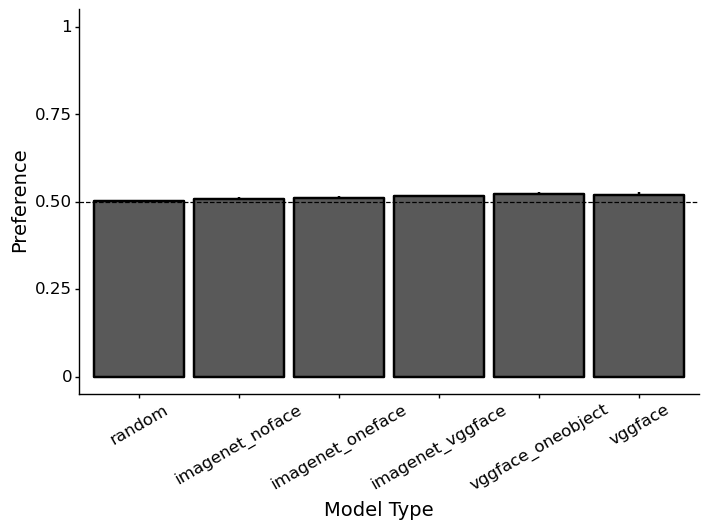


['cornet_z_sl', 'au', 'output']


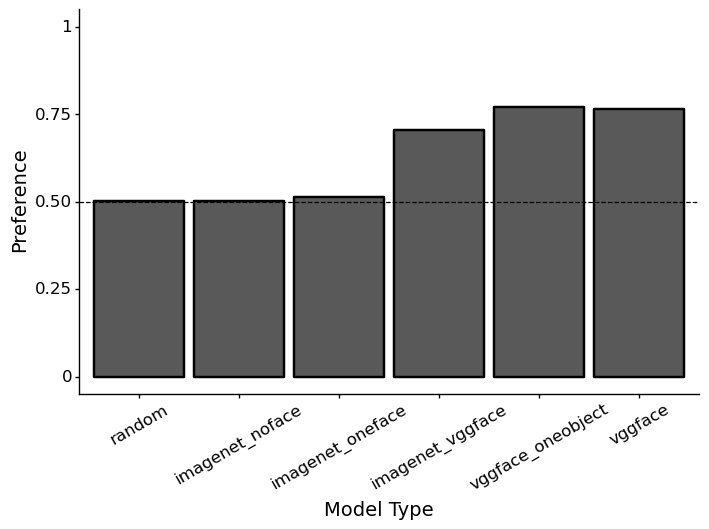

In [28]:
"""
Plot inversion preference mean data
"""
exp = 'inversion_pref'


cond = ['upright','inverted']
test_type = ['cropped_face','schematic','au']

suf = ''

for mm in enumerate(model_type):
    for ll in sublayer_type[mm[0]]:
        for tt in test_type:
            summary_df = pd.DataFrame(columns = ['arch','train_type', 'pref', 'ci_low', 'ci_high'])
            for trt in train_type:
            
            
                curr_df = pd.read_csv(f'{results_dir}/{exp}/{mm[1]}_{trt}_{ll}_{tt}{suf}.csv')
                curr_df = curr_df.loc[curr_df['test_stim'] == tt]
                
                curr_data = pd.Series([mm[1],trt,curr_df['pref'], curr_df['ci_high'],curr_df['ci_low'] ],
                                        index = summary_df.columns)
                summary_df = summary_df.append(curr_data, ignore_index=True)

                #summary_df = pd.concat([summary_df, curr_data])

            summary_df['pref'] = summary_df['pref'].astype(float)
            summary_df['ci_high'] = summary_df['ci_high'].astype(float)
            summary_df['ci_low'] = summary_df['ci_low'].astype(float)

            #summary_df['condition'] = pd.Categorical(summary_df['condition'], categories = cond, ordered = False)
            summary_df['train_type'] = pd.Categorical(summary_df['train_type'], categories = train_type, ordered = False)
            print([mm[1],tt, ll])

            plot = ggplot(summary_df, aes(x = 'train_type', y = 'pref')) + \
                    geom_linerange(aes(x='train_type',  ymax = 'ci_high', ymin = 'ci_low'), size = 1) + \
                    geom_col(stat='identity', size = 1, color = 'Black') + ylim(0,1) + \
                    geom_hline(yintercept=.5, linetype = 'dashed') + theme_classic() + xlab('Model Type') + ylab('Preference') + \
                    theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                    axis_line=element_line(), 
                                                                                    panel_border=element_blank(),
                                                                                    figure_size = (8, 5))

            print(plot)
            del plot
            

In [15]:
summary_df

,arch,train_type,pref,ci_low,ci_high
0,cornet_z_cl,random,0.502254,0.501739,0.502765
1,cornet_z_cl,imagenet_noface,0.504654,0.502781,0.506590
2,cornet_z_cl,imagenet_oneface,0.506511,0.504474,0.508556
3,cornet_z_cl,imagenet_vggface,0.678096,0.672837,0.683426
4,cornet_z_cl,vggface_oneobject,0.560179,0.556498,0.563754
...,...,...,...,...,...
103,cornet_z_sl,imagenet_noface,0.501563,0.500279,0.502829
104,cornet_z_sl,imagenet_oneface,0.513368,0.512151,0.514596
105,cornet_z_sl,imagenet_vggface,0.725087,0.722486,0.727799
106,cornet_z_sl,vggface_oneobject,0.770276,0.767780,0.772716
